# 2025 DL Lab3: Semi-Supervised Flower Classfication

Before we start, please put **your name** and **SID** in following format: <br>
Hi I'm 陸仁賈, 314831000.

**Your Answer:**    
Hi I'm 戴良育, 314834012.

## Semi-supervised Flower Classfication

In this approach, you have a dataset that includes both labeled and unlabeled examples.

The goal is to use the labeled data to train the model while also leveraging the unlabeled
data to improve the model's performance.

In this assignment, you’ll explore a self-training mechanism for this task.


**Please note that you’re not allowed to use pre-constructed models or pre-trained weights.**

## Kaggle Competition
Kaggle is an online community of data scientists and machine learning practitioners. Kaggle allows users to find and publish datasets, explore and build models in a web-based data-science environment, work with other data scientists and machine learning engineers, and enter competitions to solve data science challenges.

This assignment use kaggle to calculate your grade.  
Please use this [**LINK**](https://www.kaggle.com/t/a611e0096e5943cc99a1c0545be28c3c) to join the competition.


##  Versions of used packages

We will check PyTorch version to make sure everything work properly.

In [1]:
import sys
import torch
import torchvision
print('python', sys.version.split('\n')[0])
print('torch', torch.__version__)
print('torchvision', torchvision.__version__)

python 3.13.5 | packaged by Anaconda, Inc. | (main, Jun 12 2025, 16:37:03) [MSC v.1929 64 bit (AMD64)]
torch 2.8.0+cu126
torchvision 0.23.0+cu126


In [2]:
# Fix OpenMP conflict issue (must be at the very beginning)
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'  # Workaround for OpenMP conflict
print("✅ OpenMP conflict workaround applied")

✅ OpenMP conflict workaround applied


# Prepare Data

We use [Flowers Recognition](https://www.kaggle.com/alxmamaev/flowers-recognition) dataset.
This is collected by Alexander Mamaev.

**Abstrct**  

We clean the dataset,this dataset contains 4262 flower images.   
**IMPORTANT: you CANNOT use any extra images.**

The data collection is grabed from the data flicr, google images, yandex images.
You can use this datastet to recognize plants from the photo.

The pictures are divided into five classes:
+ daisy
+ tulip
+ rose
+ sunflower
+ dandelion

For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. Photos are not reduced to a single size, they have different proportions!

## Unzip Data

Unzip `Lab3_data_flower_2025.zip`, there are 3 folders.

- `train/`: 6 subfolders total.
   - `daisy/`, `dandelion/`, `rose/`, `sunflower/`, `tulip/`: labeled training images.
   - `unlabel/`: unlabeled training images.
contains 6 folders for 5 categories of flowers. Images of flowers inside them.
- `val/`: contains 5 folders for the same 5 classes. Labeled validation images for each class.
- `test/`: unclassified images of testing set.
---

There are **1200 images in labeled training set.**  

There are **1202 images in unlabeled training set.**

There are **678 images in validation set.**

There are **1215 images in test set.**  


## Loading the dataset

In [3]:
data_folder = 'Lab3_data_flower_2025'

### Custom dataset

Build a classs inherit `torch.utils.data.Dataset`.  
Implement `__init__`, `__getitem__` and `__len__` 3 functions.  

Some operations could be there: setting location of dataset, the method of reading data, label of dataset or transform of dataset.

See [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) for more details

In [4]:
import csv
import os.path as osp
from pathlib import Path
from PIL import Image
import torch
from torch.utils.data import DataLoader, Dataset, TensorDataset
import pandas as pd

CLASS_NAMES = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
CLASS_TO_IDX = {c:i for i, c in enumerate(CLASS_NAMES)}
VALID_EXTS = {'.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff', '.webp'}

class FlowerData(Dataset):
    def __init__(self, root, split='train', mode='train', transform=None, use_unlabel=False):
        self.root = Path(root)
        self.split = split
        self.mode = mode
        self.transform = transform
        self.use_unlabel = use_unlabel

        self.paths = []
        self.labels = []
        self.rel_paths = []

        # Load data from unified CSV files
        if split == 'train' and use_unlabel:
            csv_file = self.root / 'unlabeled_train.csv'
        elif split == 'train':
            csv_file = self.root / 'train.csv'
        elif split == 'val':
            csv_file = self.root / 'val.csv'
        else:  # test
            csv_file = self.root / 'test.csv'

        # Read CSV file using pandas for better handling
        df = pd.read_csv(csv_file)

        for _, row in df.iterrows():
            file_path = self.root / row['file_name']
            self.paths.append(file_path)
            self.rel_paths.append(row['file_name'])

            # Handle labels
            if split == 'test' or (split == 'train' and use_unlabel):
                # No labels for test or unlabeled data
                pass
            else:
                # For labeled data
                if pd.isna(row['groundtruth']) or row['groundtruth'] == '':
                    self.labels.append(-1)  # Invalid label for debugging
                else:
                    self.labels.append(CLASS_TO_IDX[row['groundtruth']])

    @property
    def targets(self):
        """Property for compatibility with WeightedRandomSampler"""
        return self.labels

    @property
    def classes(self):
        """Property for compatibility with WeightedRandomSampler"""
        return CLASS_NAMES

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        img_path = self.paths[index]
        img = Image.open(img_path).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)

        if self.mode == 'test' or (self.split == 'train' and self.use_unlabel):
            return img
        label = int(self.labels[index])
        return img, torch.tensor(label, dtype=torch.long)

## 資料預處理與分析

### 📊 資料分析工具

我們提供了獨立的資料分析工具 `analyze_data.py`，可以：

- ✅ 分析所有資料集（train, val, test, unlabeled）
- ✅ 生成類別分布圖表
- ✅ 統計圖片尺寸資訊
- ✅ 輸出詳細分析報告

**使用方式**:
```bash
# 在終端機執行
python analyze_data.py
```

**輸出檔案**:
1. `class_distribution.png` - 類別分布圖
2. `size_distribution.png` - 尺寸分布圖
3. `analysis_summary.txt` - 文字摘要報告

執行完畢後，可以根據分析結果來調整資料預處理策略。

In [6]:
# 計算類別權重以處理類別不平衡問題
import pandas as pd
import torch
from collections import Counter

def compute_class_weights(csv_path, class_names):
    """
    計算類別權重來處理不平衡資料集
    公式: weight = total_samples / (n_classes * class_count)
    
    Args:
        csv_path: 訓練資料 CSV 路徑
        class_names: 類別名稱列表
    
    Returns:
        weight_tensor: PyTorch tensor 格式的權重
    """
    df = pd.read_csv(csv_path)
    class_counts = df['groundtruth'].value_counts()
    total = len(df)
    n_classes = len(class_names)
    
    weights = {}
    for cls in class_names:
        count = class_counts.get(cls, 1)  # 避免除以零
        weight = total / (n_classes * count)
        weights[cls] = weight
    
    # 轉換為 tensor (按照 CLASS_NAMES 的順序)
    weight_tensor = torch.tensor([weights[cls] for cls in class_names], dtype=torch.float32)
    
    print("類別權重計算結果:")
    for cls, weight in weights.items():
        print(f"  {cls:12s}: {weight:.4f}")
    
    return weight_tensor


# 計算訓練集的類別權重
train_csv_path = f'{data_folder}/train.csv'
class_weights = compute_class_weights(train_csv_path, CLASS_NAMES)
print(f"\n類別權重 Tensor: {class_weights}")
print("✅ 將在訓練時使用這些權重來平衡損失函數")

類別權重計算結果:
  daisy       : 1.4724
  dandelion   : 0.6138
  rose        : 1.3636
  sunflower   : 1.7391
  tulip       : 0.7229

類別權重 Tensor: tensor([1.4724, 0.6138, 1.3636, 1.7391, 0.7229])
✅ 將在訓練時使用這些權重來平衡損失函數


### How to Use Class Weights

Later when defining the loss function, you can use the computed class weights:

```python
# 不使用類別權重 (原始方式)
criterion = nn.CrossEntropyLoss()

# 使用類別權重 (推薦,處理類別不平衡)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
```

This will give more importance to minority classes during training.

### 進階資料預處理技術

基於資料分析結果，我們將實作以下技術：

1. **加權隨機採樣器 (Weighted Random Sampler)** - 透過過採樣少數類別來解決類別不平衡
2. **MixUp 資料增強** - 混合圖片創建合成樣本
3. **CutMix 資料增強** - 替換圖片區域來增強模型泛化能力
4. **漸進式調整大小 (Progressive Resizing)** - 從小圖開始訓練，逐漸增加尺寸

這些技術已被證實能顯著提升模型的泛化能力。

In [7]:
import torch
from torch.utils.data import WeightedRandomSampler
from collections import Counter

def create_weighted_sampler(dataset):
    """
    建立加權隨機採樣器來處理類別不平衡
    透過過採樣少數類別來平衡資料集
    """
    # 從資料集取得標籤
    labels = [label.item() if torch.is_tensor(label) else label for _, label in dataset]
    
    # 計算每個類別的樣本數
    class_counts = Counter(labels)
    print("原始類別分布:")
    for cls_idx, count in sorted(class_counts.items()):
        print(f"  類別 {CLASS_NAMES[cls_idx]:12s}: {count:4d} 個樣本")
    
    # 計算每個樣本的權重
    # 權重 = 1 / (該類別的樣本數)
    class_weights_dict = {cls: 1.0 / count for cls, count in class_counts.items()}
    sample_weights = [class_weights_dict[label] for label in labels]
    
    # 建立採樣器
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True  # 允許過採樣（重複抽取）
    )
    
    print(f"\n✅ 加權採樣器已建立，共 {len(sample_weights)} 個樣本")
    print("   少數類別將在訓練時被過採樣")
    
    return sampler

# 注意：此函數會在後面需要時才呼叫
# 使用方式：weighted_sampler = create_weighted_sampler(train_set)
print("✅ 加權採樣器函數已載入")
print("   稍後可在建立 DataLoader 時使用")

✅ 加權採樣器函數已載入
   稍後可在建立 DataLoader 時使用


In [9]:
# MixUp 和 CutMix 輔助函數
import torch
import numpy as np

def mixup_data(x, y, alpha=0.2):
    """
    MixUp 資料增強：將兩個樣本混合
    論文：Zhang et al., "mixup: Beyond Empirical Risk Minimization", ICLR 2018
    
    參數:
        x: 輸入批次
        y: 標籤
        alpha: mixup 插值強度
    
    回傳:
        混合後的輸入、目標對、以及 lambda
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """
    MixUp 損失函數
    """
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


def cutmix_data(x, y, alpha=1.0):
    """
    CutMix 資料增強：在圖片間剪下並貼上區塊
    論文：Yun et al., "CutMix: Regularization Strategy to Train Strong Classifiers", ICCV 2019
    
    相較於 MixUp 更能保留空間資訊
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)

    # 取得邊界框
    _, _, H, W = x.size()
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)

    # 均勻採樣
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    # 應用 CutMix
    x[:, :, bby1:bby2, bbx1:bbx2] = x[index, :, bby1:bby2, bbx1:bbx2]
    
    # 根據實際面積比例調整 lambda
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (W * H))
    
    y_a, y_b = y, y[index]
    return x, y_a, y_b, lam


# 測試函數
print("✅ MixUp 資料增強函數已載入")
print("✅ CutMix 資料增強函數已載入")
print("\n這些函數將在訓練時用來提升模型穩健性")
print("建議參數：MixUp 使用 alpha=0.2，CutMix 使用 alpha=1.0")

✅ MixUp 資料增強函數已載入
✅ CutMix 資料增強函數已載入

這些函數將在訓練時用來提升模型穩健性
建議參數：MixUp 使用 alpha=0.2，CutMix 使用 alpha=1.0


In [17]:
def train_with_augmentation(input_data, model, criterion, optimizer, 
                           use_mixup=False, use_cutmix=False, mixup_alpha=0.2, cutmix_alpha=1.0,
                           epoch=None, total_epochs=None):
    """
    支援 MixUp/CutMix 的增強版訓練函數
    
    參數:
        use_mixup: 是否使用 MixUp 增強
        use_cutmix: 是否使用 CutMix 增強
        mixup_alpha: MixUp 插值強度 (建議 0.2)
        cutmix_alpha: CutMix 插值強度 (建議 1.0)
    """
    model.train()
    loss_list = []
    total_count = 0
    acc_count = 0

    desc = f"訓練 | epoch {epoch}/{total_epochs}" if epoch is not None else "訓練"
    pbar = tqdm(input_data, desc=desc, leave=False)

    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)
        
        # 決定是否應用資料增強（50% 機率）
        use_aug = (use_mixup or use_cutmix) and np.random.rand() > 0.5
        
        if use_aug:
            # 在 MixUp 和 CutMix 之間隨機選擇
            if use_mixup and use_cutmix:
                if np.random.rand() > 0.5:
                    images, labels_a, labels_b, lam = mixup_data(images, labels, mixup_alpha)
                else:
                    images, labels_a, labels_b, lam = cutmix_data(images, labels, cutmix_alpha)
            elif use_mixup:
                images, labels_a, labels_b, lam = mixup_data(images, labels, mixup_alpha)
            elif use_cutmix:
                images, labels_a, labels_b, lam = cutmix_data(images, labels, cutmix_alpha)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
            loss.backward()
            optimizer.step()
            
            # 計算準確率時使用主要標籤
            _, predicted = torch.max(outputs.data, 1)
            total_count += labels.size(0)
            # 使用加權組合近似準確率
            acc_count += (lam * (predicted == labels_a).sum().item() + 
                         (1 - lam) * (predicted == labels_b).sum().item())
        else:
            # 標準訓練
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs.data, 1)
            total_count += labels.size(0)
            acc_count += (predicted == labels).sum().item()
        
        loss_list.append(loss.item())
        
        running_acc = acc_count / total_count if total_count else 0.0
        lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{running_acc:.4f}", lr=f"{lr:.6f}")

    acc = acc_count / total_count if total_count else 0.0
    loss = sum(loss_list) / len(loss_list) if loss_list else 0.0
    return acc, loss


print("✅ 增強版訓練函數（支援 MixUp/CutMix）已載入")
print("   呼叫時設定 use_mixup=True 和/或 use_cutmix=True 即可啟用")

✅ 增強版訓練函數（支援 MixUp/CutMix）已載入
   呼叫時設定 use_mixup=True 和/或 use_cutmix=True 即可啟用


### 測試新增功能

讓我們測試所有新增的預處理功能是否正常運作：

In [12]:
# 測試 MixUp 和 CutMix 功能
print("=" * 60)
print("測試資料增強功能")
print("=" * 60)

# 建立測試資料
test_images = torch.randn(4, 3, 224, 224)
test_labels = torch.tensor([0, 1, 2, 3])

print(f"\n原始批次: {test_images.shape}, 標籤: {test_labels}")

# 測試 MixUp
mixed_images, labels_a, labels_b, lam = mixup_data(test_images, test_labels, alpha=0.2)
print(f"\n✓ MixUp 測試通過")
print(f"  混合圖片: {mixed_images.shape}")
print(f"  Lambda 值: {lam:.4f}")
print(f"  標籤對: {labels_a.numpy()} 和 {labels_b.numpy()}")

# 測試 CutMix
cut_images, labels_a, labels_b, lam = cutmix_data(test_images.clone(), test_labels, alpha=1.0)
print(f"\n✓ CutMix 測試通過")
print(f"  剪貼圖片: {cut_images.shape}")
print(f"  Lambda 值: {lam:.4f}")
print(f"  標籤對: {labels_a.numpy()} 和 {labels_b.numpy()}")

print("\n" + "=" * 60)
print("✅ 所有資料增強功能測試通過！")
print("=" * 60)

測試資料增強功能

原始批次: torch.Size([4, 3, 224, 224]), 標籤: tensor([0, 1, 2, 3])

✓ MixUp 測試通過
  混合圖片: torch.Size([4, 3, 224, 224])
  Lambda 值: 0.5933
  標籤對: [0 1 2 3] 和 [3 2 1 0]

✓ CutMix 測試通過
  剪貼圖片: torch.Size([4, 3, 224, 224])
  Lambda 值: 0.7447
  標籤對: [0 1 2 3] 和 [3 2 1 0]

✅ 所有資料增強功能測試通過！


### Data augmentation

Data augmentation are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data.

PyTorch use `torchvision.transforms` to do data augmentation.
[You can see all function here.](https://docs.pytorch.org/vision/main/transforms.html)  

There are some operations may not be necessary for predict, so we should write one for train and one for others.  
**NOTICE**：Please use v2 instead of transform cause some of function in v1 will be removed in the following version pytorch.

In [18]:
from torchvision.transforms import v2 as transforms
# For TRAIN
########################################################################
#  TODO: use transforms.xxx method to do some data augmentation        #
#  This one is for training, find the composition to get better result #
########################################################################
transforms_train = transforms.Compose([
    # 隨機裁切與縮放，避免直接拉伸圖片
    transforms.RandomResizedCrop(
        size=224,
        scale=(0.6, 1.0),           # 放寬取樣比例，讓視角更豐富
        ratio=(0.75, 1.33),
        antialias=True
    ),
    transforms.RandomHorizontalFlip(p=0.5),

    # 自動增強：使用 TrivialAugmentWide 或 RandAugment（二者擇一）
    transforms.TrivialAugmentWide(),
    # 若版本不支援 TrivialAugmentWide，可用 RandAugment 代替：
    # transforms.RandAugment(num_ops=2, magnitude=7),

    # 色彩抖動：使用 RandomApply 包裹，避免每張都強度過高
    transforms.RandomApply([
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1)
    ], p=0.5),

    # 少量轉灰階，提高對顏色變化的穩健度
    transforms.RandomGrayscale(p=0.05),

    # 轉成 Tensor 並做正規化
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),

    # 遮擋式正則：RandomErasing
    transforms.RandomErasing(p=0.25, scale=(0.02, 0.12), ratio=(0.3, 3.3))
])
########################################################################
#                           End of your code                           #
########################################################################

# For VAL, TEST
########################################################################
#  TODO: use transforms.xxx method to do some data augmentation        #
#  This one is for validate and test,                                  #
#  NOTICE some operation we usually not use in this part               #
########################################################################
transforms_test = transforms.Compose([
    transforms.Resize(256, antialias=True),  # 維持長寬比
    transforms.CenterCrop(224),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
########################################################################
#                           End of your code                           #
########################################################################

### Instantiate dataset

Let's instantiate three `FlowerData` class.
+ train_set: for labeled_training.
+ unlabeled_set: for unlabeled_training.
+ dataset_val: for validation.

In [19]:
train_set       = FlowerData(data_folder, split='train', mode='train', transform=transforms_train, use_unlabel=False)
unlabeled_set   = FlowerData(data_folder, split='train', mode='test',  transform=transforms_test,  use_unlabel=True)  # train/unlabel
valid_set       = FlowerData(data_folder, split='val',   mode='train', transform=transforms_test,  use_unlabel=False)

num_classes = len(CLASS_NAMES)
print("The first image's shape in dataset_train :", train_set[0][0].size())
print("There are", len(train_set), "images in labeled_dataset_train.")
print("There are", len(unlabeled_set), "images in unlabeled_dataset_train.")
print("There are", len(valid_set), "images in dataset_val.")

# Verify the new format by checking a few samples
print("\nVerifying data loading with new CSV format:")
print("Train set - first sample label:", train_set[0][1].item() if len(train_set) > 0 else "No data")
print("Train set - file path:", train_set.rel_paths[0] if len(train_set) > 0 else "No data")
print("Unlabeled set - file path:", unlabeled_set.rel_paths[0] if len(unlabeled_set) > 0 else "No data")
print("Val set - first sample label:", valid_set[0][1].item() if len(valid_set) > 0 else "No data")
print("Val set - file path:", valid_set.rel_paths[0] if len(valid_set) > 0 else "No data")

The first image's shape in dataset_train : torch.Size([3, 224, 224])
There are 1200 images in labeled_dataset_train.
There are 1202 images in unlabeled_dataset_train.
There are 678 images in dataset_val.

Verifying data loading with new CSV format:
Train set - first sample label: 0
Train set - file path: train/daisy/14167534527_781ceb1b7a_n.jpg
Unlabeled set - file path: train/unlabel/unlabel_51e2a07b21.jpg
Val set - first sample label: 0
Val set - file path: val/daisy/521762040_f26f2e08dd.jpg


### DataLoader

`torch.utils.data.DataLoader` define how to sample from `dataset` and some other function like:
+ shuffle : set to `True` to have the data reshuffled at every epoch
+ batch_size : how many samples per batch to load

See [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for more details

In [22]:
import numpy as np
import torch
from torch.utils.data import DataLoader, WeightedRandomSampler

batch_size   = 64
num_workers  = 0   # 先設 0 保證不卡

# 1) 取標籤（確保是 int）
targets = np.asarray(getattr(train_set, "labels"), dtype=np.int64)
num_classes  = len(getattr(train_set, "classes", []))

# 2) 類別計數/權重
class_counts  = np.bincount(targets, minlength=num_classes)
class_counts  = np.clip(class_counts, 1, None)
class_weights = 1.0 / class_counts
class_weights = class_weights * (num_classes / class_weights.sum())
class_weights_t = torch.tensor(class_weights, dtype=torch.float32)

# 3) 採樣器（先不設 generator）
sample_weights = class_weights[targets]
weighted_sampler = WeightedRandomSampler(
    weights=torch.as_tensor(sample_weights, dtype=torch.double),
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    train_set,
    batch_size=batch_size,
    sampler=weighted_sampler,    # << 關鍵：真的掛上去
    drop_last=True,
    num_workers=num_workers,
    pin_memory=torch.cuda.is_available()
)
val_loader   = DataLoader(valid_set, shuffle=False, pin_memory=torch.cuda.is_available())


### 選項：使用加權採樣器

如果您想使用加權隨機採樣而非在損失函數中使用類別權重：

```python
# 首先建立加權採樣器
weighted_sampler = create_weighted_sampler(train_set)

# 然後用它替換 train_loader 的定義：
train_loader = DataLoader(
    train_set, 
    batch_size=batch_size,
    sampler=weighted_sampler,  # 使用加權採樣器
    num_workers=num_workers,
    drop_last=True,
    pin_memory=torch.cuda.is_available()
)
```

**注意**：使用 sampler 時必須設定 `shuffle=False`（兩者互斥）。  
**目前設定**：我們在損失函數中使用類別權重，這樣更簡單且同樣有效。

Finally! We have made all data prepared.  
Let's go develop our model.

# Self-training

## Step 1: Supervised training

### Implement CNN using PyTorch

Try to use labeled data design and train a deep convolutional network from scratch to predict the class label of a flower image.

**Again, the goal of this assignment is for you to test different convolutional structures. You cannot directly use the blocks/architectures of pre-trained models.**

In [23]:

import torch
import torch.nn as nn

# class BasicBlock(nn.Module):
#     """
#     ResNet BasicBlock
#     """
#     expansion = 1
#     def __init__(self, in_c, out_c, stride=1, downsample=None):
#         super().__init__()
#         self.conv1 = nn.Conv2d(in_c, out_c, 3, stride, 1, bias=False)
#         self.bn1   = nn.BatchNorm2d(out_c)
#         self.relu  = nn.ReLU(inplace=True)
#         self.conv2 = nn.Conv2d(out_c, out_c, 3, 1, 1, bias=False)
#         self.bn2   = nn.BatchNorm2d(out_c)
#         self.downsample = downsample

#     def forward(self, x):
#         identity = x
#         out = self.relu(self.bn1(self.conv1(x)))
#         out = self.bn2(self.conv2(out))
#         if self.downsample is not None:
#             identity = self.downsample(x)
#         out = self.relu(out + identity)
#         return out


# def make_layer(in_c, out_c, blocks, stride):
#     """
#     創建 ResNet layer
#     """
#     down = None
#     if stride != 1 or in_c != out_c:
#         down = nn.Sequential(
#             nn.Conv2d(in_c, out_c, 1, stride, bias=False),
#             nn.BatchNorm2d(out_c)
#         )
#     layers = [BasicBlock(in_c, out_c, stride, down)]
#     for _ in range(1, blocks):
#         layers.append(BasicBlock(out_c, out_c))
#     return nn.Sequential(*layers)

# class ResNet34(nn.Module):
#     """
#     ResNet34 架構
#     Layer 結構：[3, 4, 6, 3] blocks
#     相比 ResNet18 的 [2, 2, 2, 2]，ResNet34 有更深的網路
#     """
#     def __init__(self, num_classes=5):
#         super().__init__()
#         self.stem = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
#         )
#         # ResNet34: [3, 4, 6, 3] blocks (vs ResNet18: [2, 2, 2, 2])
#         self.layer1 = make_layer(64,   64,  blocks=3, stride=1)
#         self.layer2 = make_layer(64,   128, blocks=4, stride=2)
#         self.layer3 = make_layer(128,  256, blocks=6, stride=2)
#         self.layer4 = make_layer(256,  512, blocks=3, stride=2)
#         self.avgpool = nn.AdaptiveAvgPool2d(1)
#         self.head = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(512, num_classes)
#         )

#         # Kaiming 初始化
#         for m in self.modules():
#             if isinstance(m, nn.Conv2d):
#                 nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#             elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
#                 nn.init.constant_(m.weight, 1); nn.init.constant_(m.bias, 0)
#             elif isinstance(m, nn.Linear):
#                 nn.init.normal_(m.weight, 0, 0.01); nn.init.constant_(m.bias, 0)

#     def forward(self, x):
#         x = self.stem(x)
#         x = self.layer1(x); x = self.layer2(x); x = self.layer3(x); x = self.layer4(x)
#         x = self.avgpool(x)
#         return self.head(x)

class BasicBlock(nn.Module):
    """
    ResNet BasicBlock
    完全對應 v2.py line 307-326
    """
    expansion = 1
    def __init__(self, in_c, out_c, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, 3, stride, 1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_c)
        self.relu  = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_c, out_c, 3, 1, 1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_c)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out = self.relu(out + identity)
        return out


def make_layer(in_c, out_c, blocks, stride):
    """
    創建 ResNet layer
    完全對應 v2.py line 327-338
    """
    down = None
    if stride != 1 or in_c != out_c:
        down = nn.Sequential(
            nn.Conv2d(in_c, out_c, 1, stride, bias=False),
            nn.BatchNorm2d(out_c)
        )
    layers = [BasicBlock(in_c, out_c, stride, down)]
    for _ in range(1, blocks):
        layers.append(BasicBlock(out_c, out_c))
    return nn.Sequential(*layers)

class ResNet18(nn.Module):
    """
    標準 ResNet18（不依賴 torchvision.models）
    結構：7x7 stem -> [64,128,256,512] blocks x2 -> GAP -> FC
    """
    def __init__(self, num_classes=5):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        self.layer1 = make_layer(64,   64,  blocks=2, stride=1)
        self.layer2 = make_layer(64,   128, blocks=2, stride=2)
        self.layer3 = make_layer(128,  256, blocks=2, stride=2)
        self.layer4 = make_layer(256,  512, blocks=2, stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, num_classes)
        )

        # Kaiming 初始化
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
                nn.init.constant_(m.weight, 1); nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01); nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x); x = self.layer2(x); x = self.layer3(x); x = self.layer4(x)
        x = self.avgpool(x)
        return self.head(x)



In [24]:
from torch.nn.modules.conv import Conv2d
import torch.nn as nn
import torch.nn.functional as F
class YourCNNModel(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()
        ########################################################################
        #     TODO: use nn.xxx method to generate a CNN model part             #
        ########################################################################
        self.model = ResNet18(num_classes=num_classes)  # 改用 ResNet34
        ########################################################################
        #                           End of your code                           #
        ########################################################################

    def forward(self, x):
        assert isinstance(x, torch.Tensor), "Input should be a torch Tensor"
        assert x.dim() == 4, "Input should be NHWC format"
        ########################################################################
        #     TODO: forward your model and get output                          #
        ########################################################################
        out = self.model(x)
        ########################################################################
        #                           End of your code                           #
        ########################################################################
        return out

In [25]:
device = torch.device('cuda')
# or
# device = torch.device('cpu')

In [26]:
model = YourCNNModel(num_classes=num_classes)
model = model.to(device)

We have made our model!  
Next, PyTorch also provide many utility function(loss, optmizer...etc).  
You can define them in one-line.

### Define loss and optimizer 

[Optimizers in pytorch](https://docs.pytorch.org/docs/stable/optim.html)  
[CrossEntropyLoss in pytorch](https://docs.pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

In [27]:
import torch.nn as nn
import torch.optim as optim
################################################################################
# TODO: Define loss and optmizer functions                                     #
# Try any loss or optimizer function and learning rate to get better result    #
# hint: torch.nn and torch.optim                                               #
################################################################################
# Use class weights to handle class imbalance (computed in preprocessing)
class_weights_t = torch.tensor(class_weights, dtype=torch.float32, device=device)
criterion = nn.CrossEntropyLoss(
    weight=class_weights_t,  # Use computed class weights
    label_smoothing=0.1      # Add label smoothing to prevent overfitting
)
optimizer = optim.AdamW(model.parameters(), lr=0.0015, weight_decay=1e-4)
################################################################################
#                               End of your code                               #
################################################################################
criterion = criterion.to(device)
print("Loss function configured with class weights to handle data imbalance")

Loss function configured with class weights to handle data imbalance


### Train the model

#### Train function
Let's define train function.  
It will iterate input data 1 epoch and update model with optmizer.  
Finally, calculate mean loss and total accuracy.

Hint: [torch.max()](https://pytorch.org/docs/stable/generated/torch.max.html#torch-max) or [torch.argmax()](https://pytorch.org/docs/stable/generated/torch.argmax.html)

In [29]:
from tqdm import tqdm
import torch

def train(input_data, model, criterion, optimizer, epoch=None, total_epochs=None):
    '''
    Argement:
    input_data -- iterable data, typr torch.utils.data.Dataloader is prefer
    model -- nn.Module, model contain forward to predict output
    criterion -- loss function, used to evaluate goodness of model
    optimizer -- optmizer function, method for weight updating
    '''
    model.train()
    loss_list = []
    total_count = 0
    acc_count = 0

    desc = f"Train | epoch {epoch}/{total_epochs}" if epoch is not None else "Train"
    pbar = tqdm(input_data, desc=desc, leave=False)

    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)

        ########################################################################
        # TODO: Forward, backward and optimize                                 #
        # 1. zero the parameter gradients                                      #
        # 2. process input through the network                                 #
        # 3. compute the loss                                                  #
        # 4. propagate gradients back into the network's parameters            #
        # 5. Update the weights of the network                                 #
        ########################################################################
        optimizer.zero_grad()  # 1. 清空梯度
        outputs = model(images)  # 2. 前向傳播，通過網路處理輸入
        loss = criterion(outputs, labels)  # 3. 計算損失
        loss.backward()  # 4. 反向傳播，計算梯度
        optimizer.step()  # 5. 更新網路權重
        ########################################################################
        #                           End of your code                           #
        ########################################################################


        ########################################################################
        # TODO: Get the counts of correctly classified images                  #
        # 1. get the model predicted result                                    #
        # 2. sum the number of this batch predicted images                     #
        # 3. sum the number of correctly classified                            #
        # 4. save this batch's loss into loss_list                             #
        # dimension of outputs: [batch_size, number of classes]                #
        # Hint 1: use outputs.data to get no auto_grad                         #
        # Hint 2: use torch.max()                                              #
        ########################################################################
        _, predicted = torch.max(outputs.data, 1)  # 1. 獲取預測結果（最大值的索引）
        total_count += labels.size(0)  # 2. 累加此批次的圖片數量
        acc_count += (predicted == labels).sum().item()  # 3. 累加正確分類的數量
        loss_list.append(loss.item())  # 4. 將此批次的損失加入列表
        ########################################################################
        #                           End of your code                           #
        ########################################################################

        running_acc = acc_count / total_count if total_count else 0.0
        lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{running_acc:.4f}", lr=f"{lr:.6f}")

    acc  = acc_count / total_count if total_count else 0.0
    loss = sum(loss_list) / len(loss_list) if loss_list else 0.0
    return acc, loss

#### Validate function
Next part is validate function.  
It works as training function without optmizer and weight-updating part.

In [30]:
def val(input_data, model, criterion, epoch=None, total_epochs=None):
    model.eval()
    loss_list = []
    total_count = 0
    acc_count = 0

    desc = f"Val   | epoch {epoch}/{total_epochs}" if epoch is not None else "Val"
    pbar = tqdm(input_data, desc=desc, leave=False)

    with torch.no_grad():
        for images, labels in pbar:
            images = images.to(device)
            labels = labels.to(device)

            ####################################################################
            # TODO: Get the predicted result and loss                          #
            # 1. process input through the network                             #
            # 2. compute the loss                                              #
            # 3. get the model predicted result                                #
            # 4. get the counts of correctly classified images                 #
            # 5. save this batch's loss into loss_list                         #
            ####################################################################
            outputs = model(images)  # 1. 前向傳播
            loss = criterion(outputs, labels)  # 2. 計算損失
            _, predicted = torch.max(outputs.data, 1)  # 3. 獲取預測結果

            total_count += labels.size(0)  # 4. 累加圖片數量
            acc_count += (predicted == labels).sum().item()  # 4. 累加正確分類數量
            loss_list.append(loss.item())  # 5. 儲存損失
            ####################################################################
            #                         End of your code                         #
            ####################################################################

            running_acc = acc_count / total_count if total_count else 0.0
            pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{running_acc:.4f}")

    acc  = acc_count / total_count if total_count else 0.0
    loss = sum(loss_list) / len(loss_list) if loss_list else 0.0
    return acc, loss

#### Training in a loop
Call train and test function in a loop.  
Take a break and wait.

In [31]:
################################################################################
#     You can adjust those hyper parameters to loop for max_epochs times       #
################################################################################
max_epochs = 130
log_interval = 10
# 學習率調度器：CosineAnnealingLR
# - T_max：學習率從初始值降到最小值所需的 epoch 數（設為總 epoch 數）
# - eta_min：學習率的最小值，默認為 0
# - 使用餘弦退火策略，學習率會平滑地從初始值降到最小值
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs, eta_min=0.0003)

train_acc_list = []
train_loss_list = []
val_acc_list = []
val_loss_list = []


# -------- Early stopping 參數 --------
patience = 12  # 如果驗證集連續 N 回合沒有改善就停止
best_val_loss = float('inf')
patience_counter = 0
best_model_state = None
# ------------------------------------


for epoch in range(1, max_epochs + 1):
    use_mix = (epoch >= max_epochs // 3)   # 例如後 2/3 訓練才開
    train_acc, train_loss = train_with_augmentation(
        train_loader, model, criterion, optimizer,
        use_mixup=use_mix, use_cutmix=use_mix,
        mixup_alpha=0.2, cutmix_alpha=1.0,
        epoch=epoch, total_epochs=max_epochs
    )
    val_acc, val_loss     = val(val_loader, model, criterion, epoch=epoch, total_epochs=max_epochs)

    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss)
    val_acc_list.append(val_acc)
    val_loss_list.append(val_loss)

    scheduler.step()

    # 紀錄最佳模型權重
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # 深拷貝一份模型權重
        best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        print(f"[Best updated] Saved checkpoint: {'supervised.pt'} (val_loss={best_val_loss:.6f})")
    else:
        patience_counter += 1

    # 每 log_interval 輸出一次
    if epoch % log_interval == 0:
        lr = optimizer.param_groups[0]['lr']
        print('=' * 20, f'Epoch {epoch}/{max_epochs}', '=' * 20)
        print('Train Acc: {:.6f} | Train Loss: {:.6f}'.format(train_acc, train_loss))
        print('  Val Acc: {:.6f} |   Val Loss: {:.6f} | LR: {:.6f}'.format(val_acc, val_loss, lr))

    # 判斷是否早停
    if patience_counter >= patience:
        print(f'Early stopping triggered at epoch {epoch} (val_loss 未改善 {patience} 次)')
        break

################################################################################
#                               End of your code                               #
################################################################################

[Best updated] Saved checkpoint: supervised.pt (val_loss=6.426674)


[Best updated] Saved checkpoint: supervised.pt (val_loss=1.617430)


[Best updated] Saved checkpoint: supervised.pt (val_loss=1.509497)


[Best updated] Saved checkpoint: supervised.pt (val_loss=1.500229)


[Best updated] Saved checkpoint: supervised.pt (val_loss=1.440206)
==================== Epoch 10/130 ====================
Train Acc: 0.427083 | Train Loss: 1.265863
  Val Acc: 0.392330 |   Val Loss: 1.440206 | LR: 0.001483


[Best updated] Saved checkpoint: supervised.pt (val_loss=1.366492)


[Best updated] Saved checkpoint: supervised.pt (val_loss=1.346336)


[Best updated] Saved checkpoint: supervised.pt (val_loss=1.296591)
==================== Epoch 20/130 ====================
Train Acc: 0.458333 | Train Loss: 1.214425
  Val Acc: 0.529499 |   Val Loss: 1.296591 | LR: 0.001431


[Best updated] Saved checkpoint: supervised.pt (val_loss=1.288581)


[Best updated] Saved checkpoint: supervised.pt (val_loss=1.216919)
==================== Epoch 30/130 ====================
Train Acc: 0.528646 | Train Loss: 1.128428
  Val Acc: 0.585546 |   Val Loss: 1.216919 | LR: 0.001349


[Best updated] Saved checkpoint: supervised.pt (val_loss=1.204669)


[Best updated] Saved checkpoint: supervised.pt (val_loss=1.203555)


==================== Epoch 40/130 ====================
Train Acc: 0.580729 | Train Loss: 1.067464
  Val Acc: 0.576696 |   Val Loss: 1.263345 | LR: 0.001241


[Best updated] Saved checkpoint: supervised.pt (val_loss=1.108430)


==================== Epoch 50/130 ====================
Train Acc: 0.592443 | Train Loss: 1.060926
  Val Acc: 0.634218 |   Val Loss: 1.139877 | LR: 0.001113


Early stopping triggered at epoch 54 (val_loss 未改善 12 次)


#### 選擇訓練策略

您現在有兩種訓練函數可用：

**1. 標準訓練（原始版本）**
```python
train_acc, train_loss = train(train_loader, model, criterion, optimizer, epoch, total_epochs)
```

**2. 增強訓練（支援 MixUp/CutMix）**
```python
train_acc, train_loss = train_with_augmentation(
    train_loader, model, criterion, optimizer,
    use_mixup=True,    # 啟用 MixUp
    use_cutmix=True,   # 啟用 CutMix
    mixup_alpha=0.2,   # MixUp 強度
    cutmix_alpha=1.0,  # CutMix 強度
    epoch=epoch, 
    total_epochs=total_epochs
)
```

**建議**：前 20-30 個 epoch 使用標準訓練，之後再啟用 MixUp/CutMix 以獲得最佳效果。

In [32]:
# save your well-trained state_dict of model
SUPERVISED_CKPT = 'supurvised.pt'
torch.save(model.state_dict(), SUPERVISED_CKPT)

#### Visualize accuracy and loss

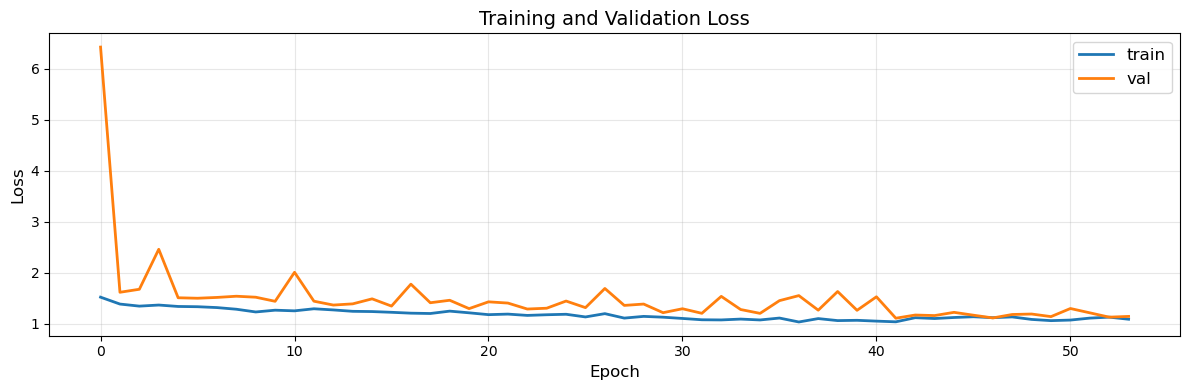

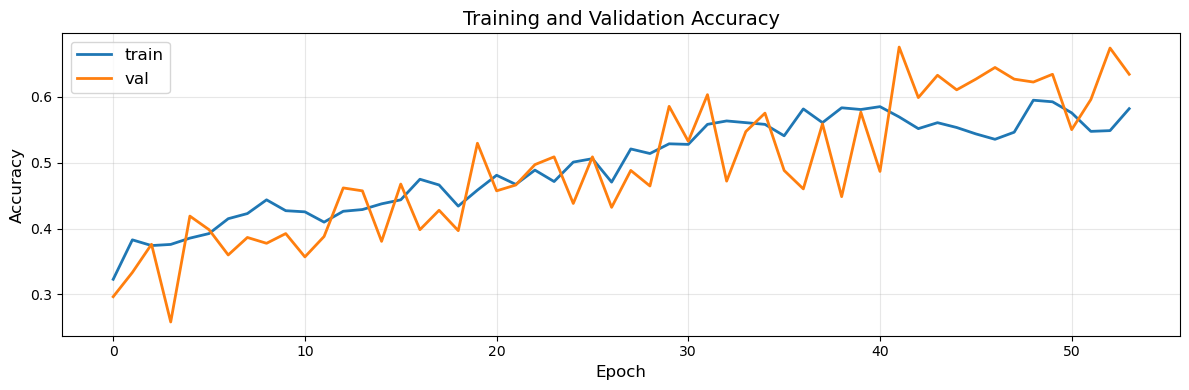


訓練完成統計：
總訓練輪數：54
最佳驗證準確率：0.6755
最終訓練準確率：0.5820
最終驗證準確率：0.6342


In [33]:
import matplotlib.pyplot as plt

# 確保變數存在且有資料
if 'train_loss_list' not in locals() or len(train_loss_list) == 0:
    print("警告：找不到訓練資料或資料為空，無法繪製圖表")
else:
    # 清除之前的圖形，避免記憶體累積
    plt.close('all')
    
    # 繪製 Loss 曲線
    plt.figure(figsize=(12, 4))
    plt.plot(range(len(train_loss_list)), train_loss_list, label='train', linewidth=2)
    plt.plot(range(len(val_loss_list)), val_loss_list, label='val', linewidth=2)
    plt.legend(loc='best', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.title('Training and Validation Loss', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    plt.close()  # 顯示後立即關閉，釋放記憶體
    
    # 繪製 Accuracy 曲線
    plt.figure(figsize=(12, 4))
    plt.plot(range(len(train_acc_list)), train_acc_list, label='train', linewidth=2)
    plt.plot(range(len(val_acc_list)), val_acc_list, label='val', linewidth=2)
    plt.legend(loc='best', fontsize=12)
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.title('Training and Validation Accuracy', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    plt.close()  # 顯示後立即關閉，釋放記憶體
    
    # 輸出統計資訊
    print(f"\n訓練完成統計：")
    print(f"總訓練輪數：{len(train_loss_list)}")
    print(f"最佳驗證準確率：{max(val_acc_list):.4f}")
    print(f"最終訓練準確率：{train_acc_list[-1]:.4f}")
    print(f"最終驗證準確率：{val_acc_list[-1]:.4f}")

finish training your classifier, next you should use this classifer to predict unlabel images with pseduo label.

## Step2: Use unlabeled data to enhance model performance

In [34]:
# load the trained classifier weights
ckpt = torch.load(SUPERVISED_CKPT, map_location=device)
model.load_state_dict(ckpt)

<All keys matched successfully>

In [35]:
# create a unlabeled data set list, we will use it later
unlabeled_set_list = []
for img in unlabeled_set:
    unlabeled_set_list.append(img)

print("Unlabeled pool size:", len(unlabeled_set_list))

Unlabeled pool size: 1202


### Use the trained classifier to generates pseudo-labels of a dataset.

In [37]:
from tqdm import tqdm
import torch.nn as nn
from torch.utils.data import ConcatDataset
###########################################################
#   You can adjust the threshold to get better result !   #
###########################################################
def get_pseudo_labels(model, threshold=0.9):

    global unlabeled_set_list
    model.eval()
    imgs_keep = []
    labels_keep = []
    remove_index = []
    soft_max = nn.Softmax(dim=1)
    with torch.no_grad():
        for idx, img in enumerate(tqdm(unlabeled_set_list, desc="Pseudo-labeling", leave=False)):
            img = img.to(device)
            img = img.unsqueeze(0)  # Add batch dimension
            #####################################################################################
            #     TODO:                                                                         #
            #     1. Foward the data, Using torch.no_grad() accelerates the forward process     #
            #     2. obtain the probability distributions by applying softmax on logits         #
            #     3. Filter the data with threshold                                             #
            #     4. Combine the labeled training data with the pseudo-labeled data             #
            #        to construct a new training set. then removed                              #
            #     5. the unlabeled data from unlabeled_set_list                                 #
            #     hint: ConcatDataset                                                           #
            #####################################################################################
            # 1. 前向傳播（已在 torch.no_grad() 中，加速推論過程）
            outputs = model(img)
            # 2. 使用 softmax 獲取機率分布
            probs = soft_max(outputs)

            # 獲取最大機率和預測類別
            max_prob, pred_label = torch.max(probs, 1)

            # 3. 根據閾值篩選資料
            if max_prob.item() >= threshold:
                # 4. 將符合閾值的圖片和標籤加入保留列表
                imgs_keep.append(img.squeeze(0).cpu())  # 移除 batch 維度並移到 CPU
                labels_keep.append(pred_label.item())
                # 5. 記錄要從未標記資料中移除的索引
                remove_index.append(idx)
            #####################################################################################
            #                           End of your code                                        #
            #####################################################################################

    # Remove processed images from unlabeled list
    for i in reversed(remove_index):
        del unlabeled_set_list[i]

    if imgs_keep:
        # Stack on CPU first, then create TensorDataset
        pseudo_imgs   = torch.stack(imgs_keep, dim=0)                      # [N, C, H, W] on CPU
        pseudo_labels = torch.tensor(labels_keep, dtype=torch.long)        # [N] on CPU
        pseudo_dataset = TensorDataset(pseudo_imgs, pseudo_labels)
        taken = len(pseudo_dataset)
    else:
        pseudo_dataset = TensorDataset(torch.empty(0,3,224,224), torch.empty(0,dtype=torch.long))
        taken = 0

    print(f"Labeled {taken} images this round. Remaining unlabeled: {len(unlabeled_set_list)}")

    # Clear GPU cache to free memory
    torch.cuda.empty_cache()

    return pseudo_dataset, taken

## Redeifine your optimizer if you want

In [38]:
################################################################################
# TODO: Define loss and optmizer functions                                     #
# Try any loss or optimizer function and learning rate to get better result    #
# hint: torch.nn and torch.optim                                               #
################################################################################
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # 保留
optimizer = optim.SGD(
    model.parameters(),
    lr=0.05,           # SGD 常用較大的初始學習率
    momentum=0.9,
    nesterov=True,
    weight_decay=1e-4
)
################################################################################
#                               End of your code                               #
################################################################################
criterion = criterion.to(device)

### Train the model

Let's define train function.  

Use the **get_pseudo_labels** function to get the new training set, then construct a new data loader for training.

It will iterate input data 1 epoch and update model with optmizer.  

Finally, calculate mean loss and total accuracy.

In [ ]:
import sys
sys.setrecursionlimit(1000000)

#########################################################################################################
#         You can adjust those hyper parameters like epochs or threshold for training                   #
#########################################################################################################
n_epochs = 100
N = 1  # Update synthesis dataset every N epochs
log_interval = 10  # Log every N epochs like supervised training
best_acc = 0.0
SELF_TRAIN_CKPT = 'self_training.pt'


patience_ssl = 8                    # 連續多少個 epoch 沒改善就停
best_val_loss_ssl = float('inf')    # 目前最佳驗證損失
patience_counter_ssl = 0            # 沒改善的累計次數

# 學習率調度器：CosineAnnealingLR (用於自我訓練階段)
# - T_max：設為自我訓練的總 epoch 數
# - eta_min：最小學習率設為初始學習率的 1/10
scheduler_ssl = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs, eta_min=5e-5)


# Initialize with original labeled data
current_train_dataset = train_set
train_loader_ssl = train_loader  # Initialize with original train loader
all_pseudo_datasets = []  # Store all pseudo datasets to accumulate them

for epoch in range(n_epochs):
    #########################################################################################################
    #    TODO:                                                                                              #
    #    In each epoch, relabel the unlabeled dataset for semi-supervised learning.                         #
    #    1. Obtain pseudo-labels for unlabeled data using trained model.(use get_pseudo_labels function)    #
    #    2. Construct a new dataset and a data loader for training.                                         #
    #    You can try different way to use the get_pseudo_label function maybe will get the better result.   #                                  #
    #########################################################################################################
    # 每 N 個 epochs 生成一次偽標籤
    if (epoch + 1) % N == 0 and len(unlabeled_set_list) > 0:
        # 1. 使用訓練好的模型為未標記資料生成偽標籤
        pseudo_dataset, taken = get_pseudo_labels(model, threshold=0.9)
        if taken > 0:
            # 只保留最近的偽標籤資料集（避免累積過多錯誤）
            all_pseudo_datasets = (all_pseudo_datasets + [pseudo_dataset])[-3:]  # 覆蓋而非累積
            # 2. 合併原始訓練集與最新的偽標籤資料，構建新訓練集
            current_train_dataset = ConcatDataset([train_set] + all_pseudo_datasets)
            # 創建新的資料載入器
            train_loader_ssl = DataLoader(current_train_dataset, shuffle=True,drop_last=True, pin_memory=torch.cuda.is_available())
    #########################################################################################################
    #                                          End of your code                                             #
    #########################################################################################################

    try:
        # ---------- Training using the train function from above ----------
        train_acc, train_loss = train(train_loader_ssl, model, criterion, optimizer, epoch=epoch+1, total_epochs=n_epochs)

        # ---------- Validation ----------
        valid_acc, valid_loss = val(val_loader, model, criterion, epoch=epoch+1, total_epochs=n_epochs)

                # >>> [Early Stopping - SSL]：以驗證損失作為是否「改善」的判準 <<<
        if valid_loss < best_val_loss_ssl:
            best_val_loss_ssl = valid_loss
            patience_counter_ssl = 0
            # 也一併更新對應的 acc 記錄（僅供觀察，不作為 early stopping 判斷）
            best_acc = max(best_acc, valid_acc)
            torch.save(model.state_dict(), SELF_TRAIN_CKPT)  # 保存目前最佳權重
        else:
            patience_counter_ssl += 1
        # <<< [Early Stopping - SSL] 結束 >>>

        # 學習率調整
        scheduler_ssl.step()

        # 記錄/輸出
        if (epoch + 1) % log_interval == 0:
            lr = optimizer.param_groups[0]['lr']
            total_pseudo = sum(len(dataset) for dataset in all_pseudo_datasets)
            print('=' * 20, f'Epoch {epoch+1}/{n_epochs}', '=' * 20)
            print('Train Acc: {:.6f} | Train Loss: {:.6f}'.format(train_acc, train_loss))
            print('  Val Acc: {:.6f} |   Val Loss: {:.6f} | LR: {:.6f}'.format(valid_acc, valid_loss, lr))
            print('Dataset Size: {} (original: {}, pseudo: {})'.format(len(current_train_dataset), len(train_set), total_pseudo))

        # >>> [Early Stopping - SSL]：達到耐心上限則提前停止 <<<
        if patience_counter_ssl >= patience_ssl:
            print(f'[SSL] Early stopping at epoch {epoch+1}: val_loss 未改善 {patience_ssl} 次，最佳 val_loss={best_val_loss_ssl:.6f}')
            break
        # <<< [Early Stopping - SSL] 結束 >>>

    except RuntimeError as e:
        print(f"CUDA error during training epoch {epoch+1}: {e}")
        torch.cuda.empty_cache()

        # Optionally reduce batch size if memory error
        if "out of memory" in str(e).lower():
            new_batch_size = max(batch_size // 2, 1)
            loader_kwargs_reduced = loader_kwargs.copy()
            loader_kwargs_reduced['batch_size'] = new_batch_size
            loader_kwargs_reduced['drop_last'] = True   # <— 補這行

            train_loader_ssl = DataLoader(
                current_train_dataset,
                shuffle=True,
                **loader_kwargs_reduced
            )

#########################################################################################################
#                               End of your code                                                        #
#########################################################################################################

Labeled 73 images this round. Remaining unlabeled: 1129


NameError: name 'loader_kwargs' is not defined

### Predict Result

Predict the labesl based on testing set. Upload to [Kaggle](https://www.kaggle.com/t/a611e0096e5943cc99a1c0545be28c3c).

**How to upload**

1. Click the folder icon in the left hand side of Colab.
2. Right click "result.csv". Select "Download"
3. To kaggle. Click "Submit Predictions"
4. Upload the result.csv
5. System will automaticlaly calculate the accuracy of 50% dataset and publish this result to leaderboard.

In [ ]:
# if you wanna load previous best model
ckpt = torch.load('self_training.pt', map_location=device)
model.load_state_dict(ckpt)

In [ ]:
test_set = FlowerData(data_folder, split='test', mode='test', transform=transforms_test)
test_loader = DataLoader(
    test_set,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False,
    pin_memory=torch.cuda.is_available()
)

In [ ]:
def predict(input_data, model):
    model.eval()
    output_list = []
    with torch.no_grad():
        for images in input_data:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            output_list.extend(predicted.to('cpu').numpy().tolist())
    return output_list

In [ ]:
pred_indices = predict(test_loader, model)

with open('result.csv', 'w', newline='') as csvFile:
    writer = csv.DictWriter(csvFile, fieldnames=['ID', 'label'])
    writer.writeheader()
    for filename, pred in zip(test_set.paths, pred_indices):
        filename = osp.basename(filename)  # Extract just the filename
        writer.writerow({'ID': filename, 'label': CLASS_NAMES[int(pred)]})

print("Saved predictions to result.csv")